<a href="https://colab.research.google.com/github/usmanmalik07/Adept-Internship/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

In [2]:
class Discriminator(nn.Module):
  def __init__(self,channels_img, features_d):
    super(Discriminator,self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(channels_img ,features_d , kernel_size =4 , stride = 2 , padding = 1),
        # Input : N x channels_img x 64 x 64
        nn.LeakyReLU(0,2),
        self._block(features_d , features_d*2 , 4 , 2 , 1), # 16x16
        self._block(features_d*2 , features_d*4 , 4 , 2 , 1), #8x8
        self._block(features_d*4 , features_d*8 , 4 , 2 , 1), # 4x4
        nn.Conv2d(features_d*8,1,kernel_size = 4,stride = 2 , padding = 0), #1x1
        nn.Sigmoid(),
        )


  def _block(self, in_channels, out_channels, kernel_size , stride , padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )
  def forward(self,x):
    return self.disc(x)


In [3]:
class Generator(nn.Module):
  def __init__(self,z_dim,channels_img,features_g):
    super(Generator,self).__init__()
    self.net = nn.Sequential(
        # input : N * z_dim * 1 * 1
        self._block(z_dim, features_g*16, 4, 1, 0), #N x f_g*16 x 4 x 4
        self._block(features_g*16,features_g*8,4,2,1), #8x8
        self._block(features_g*8,features_g*4,4,2,1), #16x16
        self._block(features_g*4,features_g*2,4,2,1), #32x32
        nn.ConvTranspose2d(features_g*2,channels_img,kernel_size=4,stride=2,padding=1),
        nn.Tanh(), #[-1,1]
    )
  def _block(self, in_channels , out_channels , kernel_size , stride , padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        )
  def forward(self,x):
    return self.net(x)



In [4]:
def initialize_weights(model):
    for m in model.modules():
      if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data,0.0,0.02)
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels, 8)
  initialize_weights(disc)
  assert disc(x).shape == (N, 1, 1, 1)
  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W)
  print("Success")

#test()

In [5]:
# setup for training model
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr = LEARNING_RATE , betas = (0.5,0.999))
opt_disc = optim.Adam(disc.parameters(), lr = LEARNING_RATE , betas = (0.5,0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(32,Z_DIM,1,1).to(device)
writer_real = SummaryWriter(f'logs/real')
writer_fake = SummaryWriter(f'logs/fake')
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
  for batch_idx, (real,_) in enumerate(loader):
    real = real.to(device)
    noise = torch.randn((BATCH_SIZE,Z_DIM,1,1)).to(device)
    fake = gen(noise)

# train disc
    disc_real = disc(real).reshape(-1)
    loss_disc_real = criterion(disc_real,torch.ones_like(disc_real))
    disc_fake = disc(fake).reshape(-1)
    loss_disc_fake = criterion(disc_fake,torch.zeros_like(disc_fake))
    loss_disc = (loss_disc_real + loss_disc_fake)/2
    disc.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_disc.step()

# train gen
    output = disc(fake).reshape(-1)
    loss_gen = criterion(output,torch.ones_like(output))
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    if batch_idx % 100 == 0:
      print(
          f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
          Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
      )
      with torch.no_grad():
        fake = gen(fixed_noise)

        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

      step += 1



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16274466.08it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490035.09it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4495187.81it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10513536.85it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Epoch [0/5] Batch 0/469           Loss D: 0.6926, loss G: 0.7677
Epoch [0/5] Batch 100/469           Loss D: 0.0155, loss G: 4.0643
Epoch [0/5] Batch 200/469           Loss D: 0.3120, loss G: 1.4813
Epoch [0/5] Batch 300/469           Loss D: 0.4409, loss G: 1.0173
Epoch [0/5] Batch 400/469           Loss D: 0.3850, loss G: 3.5909
Epoch [1/5] Batch 0/469           Loss D: 0.4445, loss G: 3.2952
Epoch [1/5] Batch 100/469           Loss D: 0.5646, loss G: 3.2272
Epoch [1/5] Batch 200/469           Loss D: 0.3989, loss G: 0.7460
Epoch [1/5] Batch 300/469           Loss D: 0.4020, loss G: 1.7036
Epoch [1/5] Batch 400/469           Loss D: 0.4984, loss G: 3.5732
Epoch [2/5] Batch 0/469           Loss D: 0.3554, loss G: 2.9778
Epoch [2/5] Batch 100/469           Loss D: 0.3141, loss G: 2.0677
Epoch [2/5] Batch 200/469           Loss D: 0.3507, loss G: 1.6058
Epoch [2/5] Batch 300/469           Loss D: 0.3187, loss G

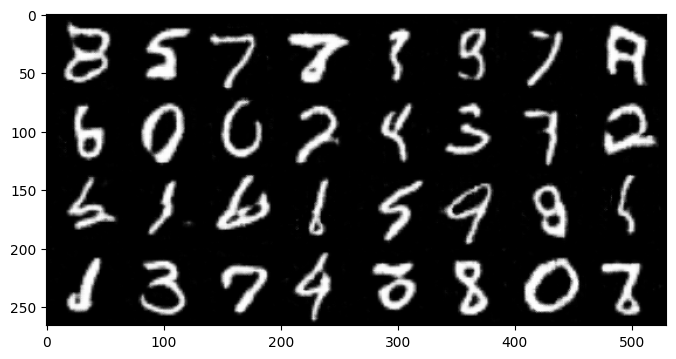

In [6]:
# visualization of the generated images



import matplotlib.pyplot as plt

def show_generated_images(generator, num_images, z_dim, device):
    noise = torch.randn(num_images, z_dim, 1, 1).to(device)
    generator.eval()
    with torch.no_grad():
        generated_images = generator(noise).cpu()


    img_grid = torchvision.utils.make_grid(generated_images, normalize=True)

    # Plot the grid of generated images
    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.show()

# Show the generated images
show_generated_images(gen, 32, Z_DIM, device)
